In [3]:
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer

In [4]:
from google.colab import drive #type: ignore
drive.mount('/content/drive') # for google colab to access google drive
import pandas as pd


data_full_path = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/data_for_text.csv'

df = pd.read_csv(data_full_path)
df.head()

Mounted at /content/drive


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.12,60148.0,192.168.10.50,22.0,6.0,6/7/2017 1:00,166.0,1.0,1.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0
1,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.50,22.0,192.168.10.12,60148.0,6.0,6/7/2017 1:00,83.0,1.0,2.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0
2,192.168.10.12-91.189.89.199-123-123-17,192.168.10.12,123.0,91.189.89.199,123.0,17.0,6/7/2017 1:00,99947.0,1.0,1.0,...,40.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0
3,192.168.10.12-72.38.129.202-123-123-17,192.168.10.12,123.0,72.38.129.202,123.0,17.0,6/7/2017 1:00,37017.0,1.0,1.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0
4,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0.0,8.0.6.4,0.0,0.0,6/7/2017 1:00,111161336.0,147.0,0.0,...,0.0,1753752.625,2123197.578,4822992.0,95.0,9463032.7,2657727.996,13600000.0,5700287.0,0


In [5]:
#70/30 train test split
X = df.drop('Label', axis=1)
y = df['Label']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1980569, 84)
(848816, 84)
(1980569,)
(848816,)


In [6]:
def textualize(X_train, X_test, y_train=None, add_label=False):
    # Helper function to convert a data row to textual format
    def to_textual(data, labels=None):
        textual_data = []
        for index, row in enumerate(data.values):
            row_textual = [f"{col}: {val}" for col, val in zip(data.columns, row)]
            if add_label and labels is not None:
                row_textual.append(f"label: {labels.iloc[index]}")
            textual_data.append(' '.join(row_textual))
        return textual_data

    train_x_textual = to_textual(X_train, y_train if add_label else None)
    test_x_textual = to_textual(X_test)  # Labels typically not needed for test data in description generation

    return train_x_textual, test_x_textual

x_train_textual, x_test_textual = textualize(X_train, X_test)

In [7]:
import re

def process_all_numbers(text):
    def f(match):
        num = match.group(0)
        integer_part = match.group(1)
        integer_length = len(integer_part)
        decimal_part = match.group(3)
        decimal_length = len(decimal_part) if decimal_part else 0

        if decimal_part:
            prefix = f'<sn>{integer_length}.{decimal_length}<mn>'
        else:
            prefix = f'<sn>{integer_length}<mn>'

        return prefix + num + '<en>'

    pattern = r'(\d+)(\.(\d+))?'
    return re.sub(pattern, f, text)



train_processed_text = []
test_processed_text = []

for string in x_train_textual:
    processed_string = process_all_numbers(string)
    train_processed_text.append(processed_string)

for string in x_test_textual:
    processed_string = process_all_numbers(string)
    test_processed_text.append(processed_string)


print("Before Process:")
print(x_train_textual[0])



print("\nPost-Processed String:")
print(train_processed_text[0])

def embed_data(train_text, test_text):
    # embed data with LLM
    llm_model = SentenceTransformer(r"sentence-transformers/paraphrase-MiniLM-L6-v2")
    embeddings_train = llm_model.encode(train_text, show_progress_bar=True, normalize_embeddings=True)
    embeddings_test = llm_model.encode(test_text, show_progress_bar=True, normalize_embeddings=True)
    return embeddings_train, embeddings_test

embeddings_train, embeddings_test = embed_data(train_processed_text, test_processed_text)
print(embeddings_train.shape)
print(embeddings_test.shape)

Before Process:
Flow ID: 192.168.10.25-52.84.145.252-56104-443-6 Source IP: 192.168.10.25 Source Port: 56104.0 Destination IP: 52.84.145.252 Destination Port: 443.0 Protocol: 6.0 Timestamp: 4/7/2017 1:31 Flow Duration: 183352.0 Total Fwd Packets: 20.0 Total Backward Packets: 32.0 Total Length of Fwd Packets: 871.0 Total Length of Bwd Packets: 42347.0 Fwd Packet Length Max: 389.0 Fwd Packet Length Min: 0.0 Fwd Packet Length Mean: 43.55 Fwd Packet Length Std: 103.3779346 Bwd Packet Length Max: 2896.0 Bwd Packet Length Min: 0.0 Bwd Packet Length Mean: 1323.34375 Bwd Packet Length Std: 651.7786389 Flow Bytes/s: 235710.5458 Flow Packets/s: 283.6074872 Flow IAT Mean: 3595.137255 Flow IAT Std: 7777.66222 Flow IAT Max: 29345.0 Flow IAT Min: 1.0 Fwd IAT Total: 183352.0 Fwd IAT Mean: 9650.105263 Fwd IAT Std: 10809.81275 Fwd IAT Max: 29345.0 Fwd IAT Min: 1.0 Bwd IAT Total: 147598.0 Bwd IAT Mean: 4761.225806 Bwd IAT Std: 12856.79175 Bwd IAT Max: 52952.0 Bwd IAT Min: 48.0 Fwd PSH Flags: 0.0 Bwd PSH

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/61893 [00:00<?, ?it/s]

Batches:   0%|          | 0/26526 [00:00<?, ?it/s]

(1980569, 384)
(848816, 384)


In [8]:
from sklearn.decomposition import PCA

def apply_pca(X_train, X_test, variance_threshold=0.95):
    # Fit PCA on training data
    pca = PCA(n_components=variance_threshold, svd_solver='full')
    pca.fit(X_train)

    # Transform both train and test data
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    n_components = pca.n_components_
    print(f"Number of components selected: {n_components}")
    print(f"Cumulative explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

    return X_train_pca, X_test_pca, n_components

# Apply PCA to embeddings
embeddings_train_pca, embeddings_test_pca, n_components = apply_pca(embeddings_train, embeddings_test)

print(embeddings_train_pca.shape)
print(embeddings_test_pca.shape)
print(f"Number of components selected: {n_components}")

Number of components selected: 47
Cumulative explained variance ratio: 0.9506
(1980569, 47)
(848816, 47)
Number of components selected: 47


In [9]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns #for plots
#our models and ML tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm  # Import tqdm for notebook usage

rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
etc = ExtraTreesClassifier()
svc = SVC()
knn = KNeighborsClassifier()
lr = LogisticRegression()

models = [rfc, abc, gbc, etc, lr, knn]
model_names = ['Random Forest', 'AdaBoost', 'Gradient Boost', 'Extra Trees', 'Logistic Regression', 'KNN']

def predicting_anomaly(X_train, X_test, y_train, y_test, models, names): #define prediction function
  display(HTML('<h1>Predicting Anomaly</h1>')) #display HTML

  def training(model, name, axes): #define training function
    model.fit(X_train, y_train) #fit the model
    pred = model.predict(X_test) #predict the values
    score = accuracy_score(y_test, pred) #obtain score
    report = classification_report(y_test, pred) #obtain report
    cm = confusion_matrix(y_test, pred) #obtain CM
    sns.heatmap(cm, annot=True, ax=axes) #optain heatmap
    axes.set_title("{}: {}%".format(name, round(score*100, 2))) #display formatting
    return score*100, report #returned results

  display(HTML('<h1>Training and evaluation of Network Traffic Binary Prediction</h1>')) #display HTML

  #create plots
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,7)) #create plots
  index = 0
  scores, reports = [], dict()
  for i in tqdm(range(2), desc="Row Progress"):
        for j in tqdm(range(3), desc="Column Progress", leave=False):
            print("Current Model: ", names[index])
            score, report = training(models[index], names[index], axes[i][j])
            reports[names[index]] = report
            index += 1
            scores += [score]
  plt.tight_layout()
  plt.show()

  dt = pd.DataFrame({"scores": scores}, index=names)
  dt = dt.sort_values("scores", ascending=False)
  dt["scores"] = round(dt["scores"], 2)
  fig, axes = plt.subplots()
  sns.barplot(x=dt.index, y=dt.iloc[:, 0], ax=axes)
  for container in axes.containers:
      axes.bar_label(container)
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
  axes.set_xlabel("Model Names")
  axes.set_title("Model Accuracy")
  plt.show()

  for i in dt.index:
        print("*"*30)
        print(i)
        print(reports[i])
        print("\n\n")

Row Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Random Forest
Current Model:  AdaBoost


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Current Model:  Gradient Boost


Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Extra Trees
Current Model:  Logistic Regression
Current Model:  KNN


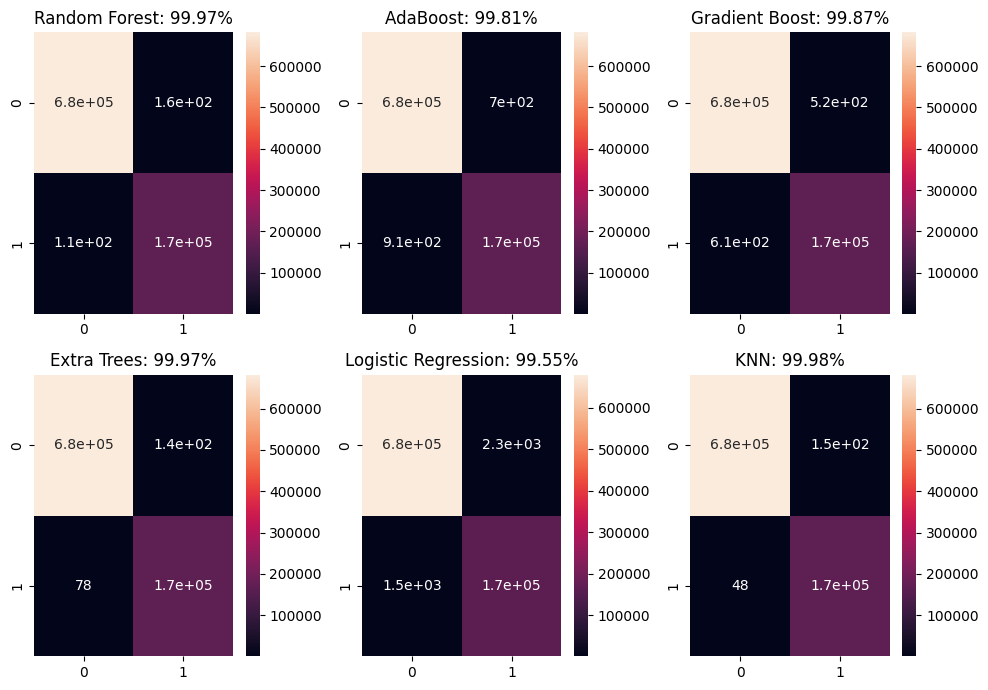

<ipython-input-9-c490f2783530>:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


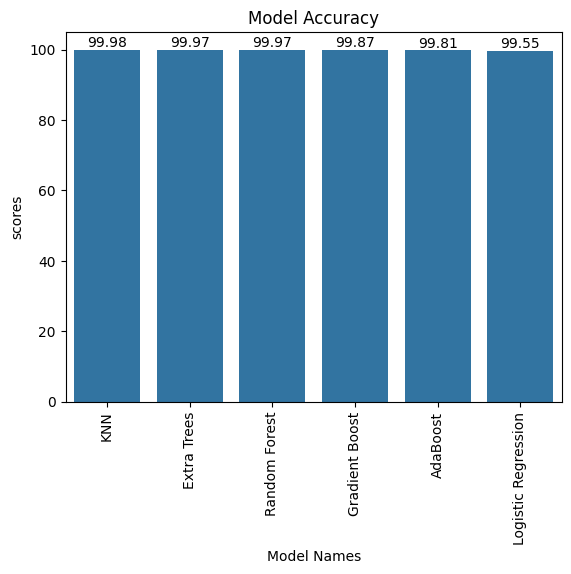

******************************
KNN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    682254
           1       1.00      1.00      1.00    166562

    accuracy                           1.00    848816
   macro avg       1.00      1.00      1.00    848816
weighted avg       1.00      1.00      1.00    848816




******************************
Extra Trees
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    682254
           1       1.00      1.00      1.00    166562

    accuracy                           1.00    848816
   macro avg       1.00      1.00      1.00    848816
weighted avg       1.00      1.00      1.00    848816




******************************
Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    682254
           1       1.00      1.00      1.00    166562

    accuracy                           1.00    848816

In [10]:
predicting_anomaly(embeddings_train_pca, embeddings_test_pca, y_train, y_test, models, model_names)